In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
df = pd.read_csv("./datasets/SMSSpamCollection.csv",header=None,names=["label","text"])
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud

class Multinomial_NB:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, Y):
        labels, label_counts = np.unique(Y, return_counts=True)
        self.labels = labels
        self.label_counts = label_counts
        pi_c = np.array([])
        theta_jc = dict()
        
        for c in range(len(labels)):
            temp = (self.alpha + label_counts[c])/((self.alpha * len(labels)) + len(Y))
            pi_c = np.append(pi_c, temp)
        
        classes = np.array([])
        for c in range(len(labels)):
            class_dict = dict(name=labels[c], words=np.array([]))
        
        words_dict = dict()
        total_word_count = dict()
        for i in range(len(X)):
            words, word_counts = np.unique(X[i], return_counts=True)
            current_class = Y[i]
            
            if current_class in total_word_count:
                total_word_count[current_class] += len(X.shape[1])
            else:
                total_word_count[current_class] = len(X.shape[1])
            
            for j in range(len(words)):
                if words[j] in words_dict:
                    words_dict[words[j]][current_class] += word_counts[j]
                else:
                    words_dict[words[j]] = dict()
                    words_dict[words[j]][current_class] = word_counts[j]
                    
        for j in len(words_dict):
            words_dict_keys = words_dict.keys()
            word_classes_dict = dict()
            
            for c in len(words_dict[words_dict_keys[j]]):
                classes_dict_keys = words_dict[words_dict_keys[j]].keys()
                temp = (self.alpha + words_dict[words_dict_keys[j]][classes_dict_keys[c]])/((self.alpha * X.shape[1]) + total_word_count[classes_dict_keys[c]])
                theta_jc[words_dict[j]] = dict()
                theta_jc[words_dict[j]][classes_dict_keys[c]] = temp
                 
        self.pi_c = pi_c
        self.theta_jc = theta_jc
    
    def predict(self, X):
        log_l = np.array([])
        for i in range(len(X)):
            words, word_counts = np.unique(X[i], return_counts=True)
            row_class_probs = dict()
            for c in range(len(self.labels)):
                temp_log_pi = np.log(self.pi_c[c]**self.label_counts[c])
                
                temp_log_sum_theta = 0
                for j in range(X.shape[1]):
                    word_count = word_counts[words.index(X[i,j])]
                    temp = (self.theta_jc[X[i,j]]**word_count)*((1-self.theta_jc[X[i,j]])**(X.shape[1]-word_count))
                    temp_log_sum_theta += np.log(temp)
                
                row_class_probs[self.labels[c]] = temp_log_pi + temp_log_sum_theta
            
            class_chosen = row_class_probs.keys()[0]
            for key in row_class_probs:
                if row_class_probs[key] > row_class_probs[class_chosen]:
                    class_chosen = key

            log_l = np.append(log_l, class_chosen)
        
        return log_l
    
    def predict_proba(self, X):
        pass
    
    def predict_log_proba(self, X):
        pass

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mattb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
df['length'] = df['text'].map(lambda text: len(text))
df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4827.0,71.527035,58.330761,2.0,33.0,52.0,93.0,910.0
spam,747.0,139.119143,28.998900,13.0,133.0,149.0,158.0,224.0


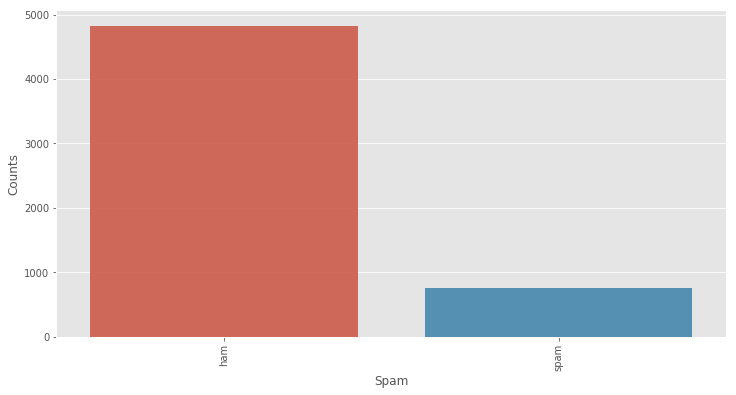

In [15]:
label_counts = df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [30]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)))
df['text_stemmed'] = df['text'].map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text)))

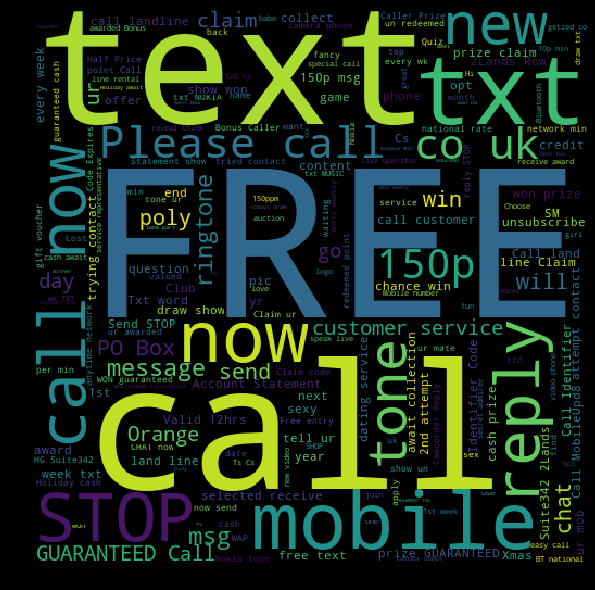

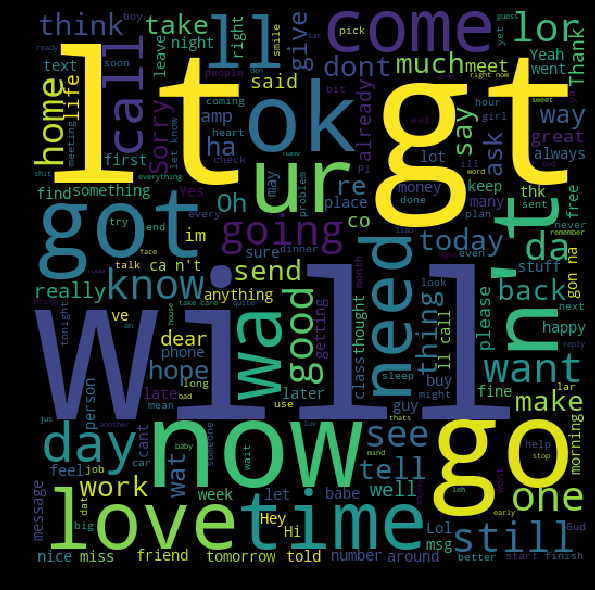

In [38]:
df.describe()
spam_words = ''.join(list(df[df['label']=='spam']['text_lemmatized']))
spam_wordcloud = WordCloud(width=512, height=512).generate(spam_words)
ham_words = ''.join(list(df[df['label']=='ham']['text_lemmatized']))
ham_wordcloud = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
def onehot(Y):  
    U_index = np.unique(Y, return_inverse=1)[1]
    Y_one_hot=(U_index.ravel()[:,None] == np.arange(U_index.max()+1)).astype(int)
    return Y_one_hot
def softmax(score):
    Y_proba=np.exp(score).T/(np.sum(np.exp(score),axis=1))
    return Y_proba.T
def cross_entropy_loss(Y_one_hot, Y_proba):
    ce_cost=-Y_one_hot*np.log2(Y_proba)
    return ce_cost[np.nonzero(ce_cost)].mean()

In [ ]:
class Softmax_Regression:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None,lambd=0.0,early_stopping=False, validation_fraction=0.1,**kwargs):
        Y=onehot(Y)
        bias_term=np.ones((X.shape[0], 1))
        X=np.hstack((bias_term,X))
        theta=np.zeros((X.shape[1], Y.shape[1]))
        for i in range(epochs):
            scores=X.dot(theta)
            Y_proba=softmax(scores)
            ce=cross_entropy_loss(Y, Y_proba)
            if regularizer==None:
                theta=theta-(learning_rate/X.shape[0])*np.dot(X.T,(Y_proba-Y))
            elif regularizer=='l1':
                theta=theta-(learning_rate/X.shape[0]*np.dot(X.T,(Y_proba-Y))+lambd*np.sign(theta))
            else:
                theta=theta-(learning_rate/X.shape[0]*np.dot(X.T,(Y_proba-Y))+lambd*theta)
            new_scores=X.dot(theta)
            new_Y_proba=softmax(scores)
            new_ce=cross_entropy_loss(Y, Y_proba)
 
            if tol is not None:
                if new_ce > ce-tol:
                    break
        self.theta=theta
        
    def predict(self, X):
        bias_term=np.ones((X.shape[0], 1))
        X=np.hstack((bias_term,X))
        scores=X.dot(self.theta)
        Y_proba=softmax(scores)
        return np.argmax(Y_proba,axis=1)
    